<a href="https://colab.research.google.com/github/tkwang312/tensorflow-apcs-data/blob/main/APCSA_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [109]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('gdrive/My Drive/historical.csv')
np.set_printoptions(precision=3, suppress=True)

df1 = df.copy()
pop = df1.pop('Pop')

thirteen = df1.pop('2013')
thirteen = np.array(thirteen)
proportion = []
proportion = np.divide(thirteen, pop) * 100


inputs = {}

for name, column in df.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs


{'state': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'state')>,
 '1998': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '1998')>,
 '1999': <KerasTensor: shape=(None, 1) dtype=string (created by layer '1999')>,
 '2000': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '2000')>,
 '2001': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '2001')>,
 '2002': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '2002')>,
 '2003': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '2003')>,
 '2004': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '2004')>,
 '2005': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '2005')>,
 '2006': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '2006')>,
 '2007': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '2007')>,
 '2008': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '2008')>,
 '2009': <KerasTensor: shape

In [110]:
numeric_inputs = {name:input for name,input in inputs.items() if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(df[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'normalization_6')>

Normalize

In [111]:
preprocessed_inputs = [all_numeric_inputs]

In [112]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = layers.StringLookup(vocabulary=np.unique(df[name]))
  one_hot = layers.CategoryEncoding(max_tokens=lookup.vocab_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

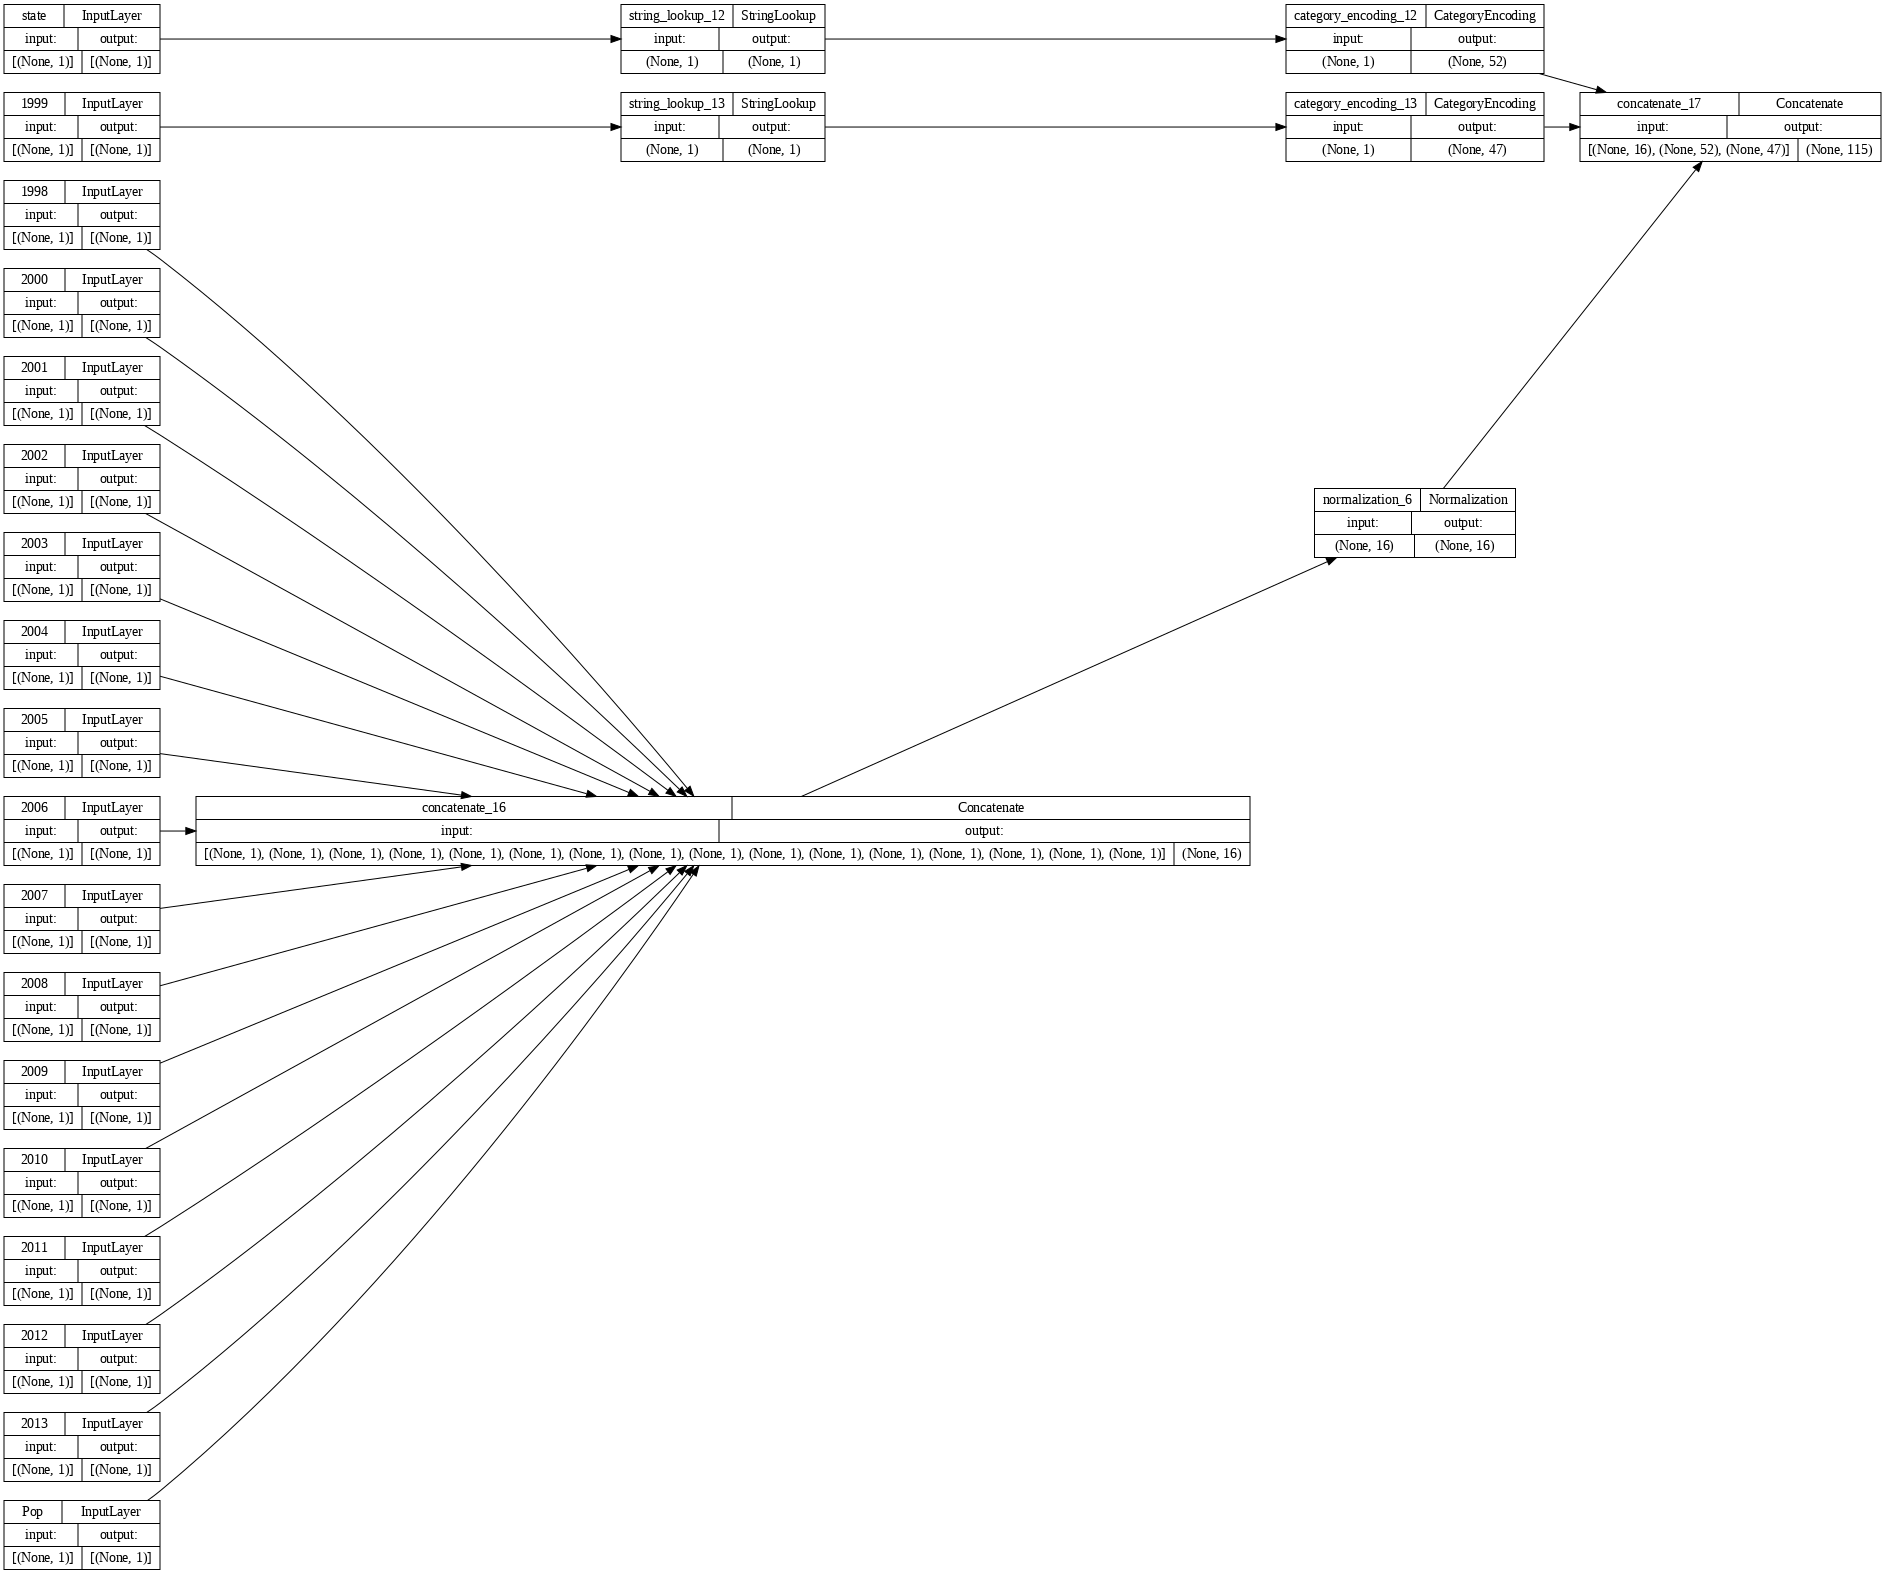

In [113]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

df_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = df_preprocessing , rankdir="LR", dpi=72, show_shapes=True)


In [114]:
df_dict = {name: np.array(value) 
                         for name, value in df.items()}

In [115]:
features_dict = {name:values[:1] for name, values in df_dict.items()}
df_preprocessing(features_dict)

<tf.Tensor: shape=(1, 115), dtype=float32, numpy=
array([[3.705, 4.471, 4.529, 4.268, 4.47 , 3.979, 4.038, 4.009, 3.723,
        3.458, 3.286, 3.668, 3.823, 4.272, 4.624, 4.617, 0.   , 0.   ,
        0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)>

In [116]:
def APCSA_Model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.optimizers.Adam())
  return model
APCSA_Model = APCSA_Model(df_preprocessing, inputs)


In [117]:
x = df_dict
y = proportion

APCSA_Model.fit(x, y, epochs = 50, batch_size = 1)

Epoch 1/50
51/51 [==============================] - 1s 2ms/step - loss: 0.7556
Epoch 2/50
51/51 [==============================] - 0s 2ms/step - loss: 0.3562
Epoch 3/50
51/51 [==============================] - 0s 2ms/step - loss: 0.2227
Epoch 4/50
51/51 [==============================] - 0s 3ms/step - loss: 0.1521
Epoch 5/50
51/51 [==============================] - 0s 2ms/step - loss: 0.1083
Epoch 6/50
51/51 [==============================] - 0s 2ms/step - loss: 0.0827
Epoch 7/50
51/51 [==============================] - 0s 2ms/step - loss: 0.0691
Epoch 8/50
51/51 [==============================] - 0s 2ms/step - loss: 0.0597
Epoch 9/50
51/51 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 10/50
51/51 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 11/50
51/51 [==============================] - 0s 2ms/step - loss: 0.0477
Epoch 12/50
51/51 [==============================] - 0s 2ms/step - loss: 0.0459
Epoch 13/50
51/51 [==============================

Text(0.5, 1.0, 'model loss')

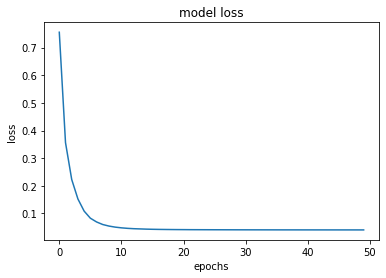

In [118]:
loss = APCSA_Model.history.history['loss']
plt.plot(loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('model loss')

In [119]:
# state = df1.pop('state')

# # population = df.pop('Pop')
# # population = np.array(population)


# # thirteen = df1.pop('2013')
# # thirteen = np.array(thirteen)

# proportion = []

# proportion = np.divide(thirteen, population) * 100


# model = tf.keras.Sequential([
#   layers.Dense(64),
#   layers.Dense(1)
# ])

# model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam())

# model.fit(df1, state, epochs=10)

TensorSpec(shape=(10,), dtype=tf.float32, name=None)